**References:**

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html \
https://www.tensorflow.org/text/tutorials/nmt_with_attention \
https://www.youtube.com/watch?v=0_PgWWmauHk&t=437s \
https://www.youtube.com/watch?v=f-JCCOHwx1c \
https://chat.openai.com/chat \


# **Loading the dataset & libraries**

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
import datasets
from datasets import Dataset
from tensorflow.data import Dataset
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Layer
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.activations import tanh, softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

import unicodedata
import os
import io
import time
from sklearn.model_selection import train_test_split

In [ ]:
# Load the dataset
dataset = datasets.load_dataset('wmt16', 'de-en')

train_data = dataset['train'][:5000]
val_data = dataset['validation']
test_data = dataset['test']

  0%|          | 0/3 [00:00<?, ?it/s]

# **Preprocessing**

In [ ]:
def process_data(data_set):
    processed_data = []
    for pair in data_set['translation']:
        temp = [pair['en'], pair['de']]
        processed_data.append(temp)

    data = array(processed_data)

    # Remove punctuation
    data[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,0]]
    data[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,1]]

    # convert to lowercase
    for i in range(len(data)):
        data[i,0] = data[i,0].lower()
        data[i,1] = data[i,1].lower()

    english_language = data[:, 0]
    german_language = data[:, 1]

    return english_language, german_language

In [ ]:
def preprocess_sentence(w):
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
# Remove the accents, clean the sentences
def create_dataset(language):
    language = [preprocess_sentence(sent) for sent in language]
    return language

In [ ]:
def tokenize(lang):
  lang_tokenizer = Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  return lang_tokenizer

def encode_seq(tokenizer, leng, data):
  tensor = tokenizer.texts_to_sequences(data)
  tensor = pad_sequences(tensor,  maxlen=leng, padding='post')
  return tensor

In [ ]:
train_eng, train_german = process_data(train_data)
val_eng, val_german = process_data(val_data)
test_eng, test_german = process_data(test_data)


train_eng, train_german = list(train_eng), list(train_german)
val_eng, val_german = list(val_eng), list(val_german)
test_eng, test_german = list(test_eng), list(test_german)

In [ ]:
train_english = create_dataset(train_eng)
train_german = create_dataset(train_german)

val_english = create_dataset(val_eng)
val_german = create_dataset(val_german)

test_english = create_dataset(test_eng)
test_german = create_dataset(test_german)

In [ ]:
english_vocab = train_english + val_english + test_english
german_vocab = train_german + val_german + test_german

In [ ]:
english_tokenizer = tokenize(english_vocab)
german_tokenizer = tokenize(german_vocab)

In [ ]:
english_vocabulary = len(english_tokenizer.word_index) + 1
german_vocabulary = len(german_tokenizer.word_index) + 1

english_max_length = 161
german_max_length = 152

print(f"English: {english_max_length}, German: {german_max_length}")

English: 161, German: 152


In [ ]:
# prepare training data
trainX = encode_seq(english_tokenizer, english_max_length, train_english)
trainY = encode_seq(german_tokenizer, german_max_length, train_german)

# prepare validation data
valX = encode_seq(english_tokenizer, english_max_length, val_english)
valY = encode_seq(german_tokenizer, german_max_length, val_german)

# prepare test data
testset_X = encode_seq(english_tokenizer, english_max_length, test_english)
testset_Y = encode_seq(german_tokenizer, german_max_length, test_german)

In [ ]:
# storing the tokenizers
import pickle

with open('english_tokenizer.pkl', 'wb') as file:
  pickle.dump(english_tokenizer, file)

with open('german_tokenizer.pkl', 'wb') as file:
  pickle.dump(german_tokenizer, file)

# **b) Vanilla LSTM**

In [ ]:
# build basic LSTM model
def create_LSTM_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model = create_LSTM_model(english_vocabulary, german_vocabulary, english_max_length, german_max_length, 512)
adam = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

In [ ]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    validation_data=(valX, valY.reshape(valY.shape[0], valY.shape[1], 1)),
                    epochs=10, batch_size=64)

Epoch 1/10
79/79 [==============================] - 36s 392ms/step - loss: 1.8310 - val_loss: 1.1848
Epoch 2/10
79/79 [==============================] - 30s 382ms/step - loss: 1.3657 - val_loss: 1.2998
Epoch 3/10
79/79 [==============================] - 30s 381ms/step - loss: 1.2113 - val_loss: 1.1158
Epoch 4/10
79/79 [==============================] - 30s 379ms/step - loss: 1.1762 - val_loss: 1.0686
Epoch 5/10
79/79 [==============================] - 30s 381ms/step - loss: 1.1501 - val_loss: 1.0719
Epoch 6/10
79/79 [==============================] - 30s 379ms/step - loss: 1.1381 - val_loss: 1.0718
Epoch 7/10
79/79 [==============================] - 30s 380ms/step - loss: 1.2074 - val_loss: 1.1172
Epoch 8/10
79/79 [==============================] - 30s 381ms/step - loss: 1.1492 - val_loss: 1.0780
Epoch 9/10
79/79 [==============================] - 30s 382ms/step - loss: 1.1225 - val_loss: 1.0954
Epoch 10/10
79/79 [==============================] - 30s 385ms/step - loss: 1.1097 - val_lo

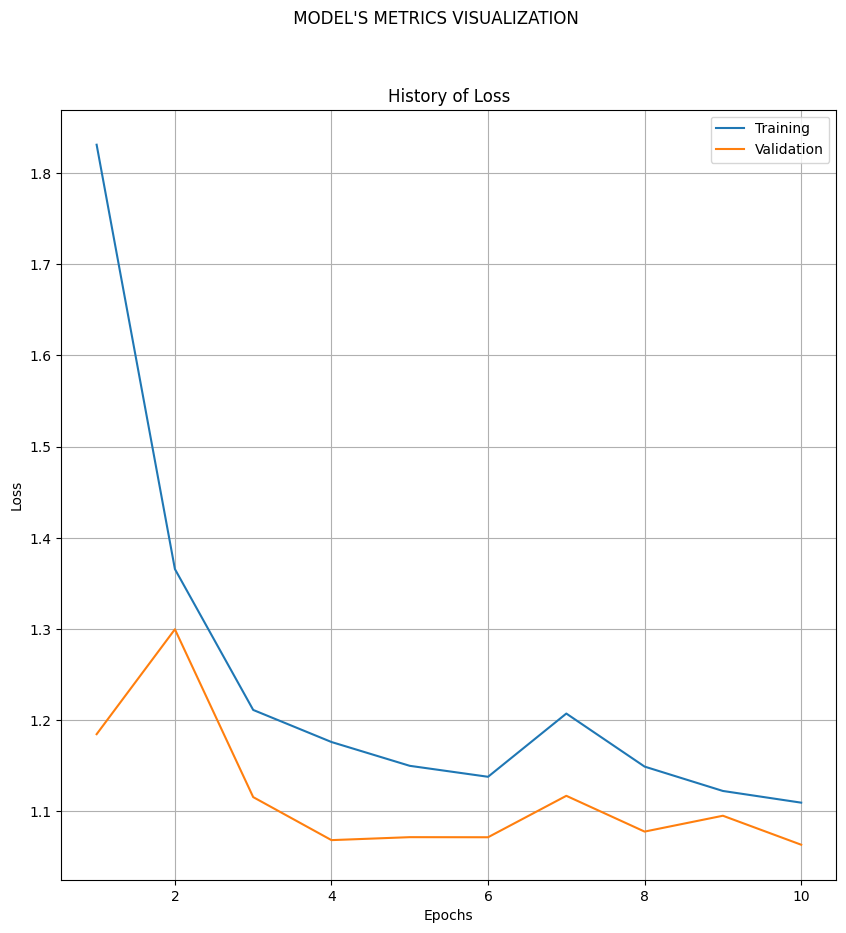

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 10))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
ax1.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
ax1.set_title('History of Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['Training', 'Validation'])
ax1.grid()
plt.show()

In [ ]:
# saving the model
model.save('english_to_german_lstm')

## **Loading the model, and testing the performance on the test set**
### here, we are slicing the test set into 10 chunks.

In [ ]:
# loading the model
model = load_model('/content/english_to_german_lstm')

# breaking test set into chunks
test_chunks = np.array_split(testset_X, 30, axis=0)
test_y_chunks = np.array_split(testset_Y, 30, axis=0)

In [ ]:
# method to store predictions of each chunk
def make_predictions(chunks):
  prediction_chunk = []
  
  for test_set in chunks:
    predictions = np.argmax(model.predict(test_set.reshape((test_set.shape[0], test_set.shape[1]))), axis=-1)
    prediction_chunk.append(predictions)

  return prediction_chunk

In [ ]:
predictions_chunk = make_predictions(test_chunks)
predictions_chunk[0].shape

4/4 [==============================] - 0s 73ms/step


(100, 152)

In [ ]:
def convert_to_words(data):
  result = []
  for row in data:
    row = list(row)
    row = [x for x in row if x != 0]

    temp_list = []
    for token in row:
      temp_list.append(german_tokenizer.index_word[token])

    temp_list = ' '.join(temp_list)
    result.append(temp_list)

  return array(result)

In [ ]:
predicted_words = []
actual_words = []

for predicted_tokens, test_y in zip(predictions_chunk, test_y_chunks):
  predicted_words.append(convert_to_words(predicted_tokens))
  actual_words.append(convert_to_words(test_y))

# **c) Global Attention Model**

In [ ]:
# Creating a tf.data Dataset
BUFFER_SIZE = len(trainX)
BATCH_SIZE = 32
steps_per_epoch = len(trainX) // BATCH_SIZE
embedding_dim = 128
units = 512

vocab_inp_size = len(english_tokenizer.word_index) + 1
vocab_tar_size = len(german_tokenizer.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((valX, valY)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 161]), TensorShape([32, 152]))

In [ ]:
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(self.enc_units,
                     return_sequences=True,
                     return_state=True,
                     recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state_h, state_c = self.lstm(x, initial_state=hidden)
    return output, [state_h, state_c]

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)),
            tf.zeros((self.batch_sz, self.enc_units))]

class GlobalAttention(Layer):
  def __init__(self, units):
    super(GlobalAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query[0], 1)
    score = self.V(tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(self.dec_units,
                   return_sequences=True,
                   return_state=True,
                   recurrent_initializer='glorot_uniform')
    self.fc = Dense(vocab_size)
    self.attention = GlobalAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state_h, state_c = self.lstm(x, initial_state=hidden)
    state = [state_h, state_c]
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print('Encoder Output Shape: (batch_size, sequence_length, units)', sample_output.shape)
print('Encoder Hidden State Shape: (batch_size, units)', sample_hidden[0].shape)

Encoder Output Shape: (batch_size, sequence_length, units) (32, 161, 512)
Encoder Hidden State Shape: (batch_size, units) (32, 512)


In [ ]:
attention_layer = GlobalAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention Result Shape: (batch_size, units)", attention_result.shape)
print("Attention Weights Shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention Result Shape: (batch_size, units) (32, 512)
Attention Weights Shape: (batch_size, sequence_length, 1) (32, 161, 1)


In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, sample_decoder_state, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder Output Shape: (batch_size, vocab_size)', sample_decoder_output.shape, sample_decoder_state[0].shape)

Decoder Output Shape: (batch_size, vocab_size) (32, 26333) (32, 512)


In [ ]:
from keras.optimizers.legacy.rmsprop import RMSprop

optimizer = RMSprop()
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.not_equal(real, 0)
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [ ]:
EPOCHS = 5

train_loss = []
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_train_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    train_batch_loss = train_step(inp, targ, enc_hidden)
    total_train_loss += train_batch_loss
  
  temp = "{:.4f}".format(total_train_loss/steps_per_epoch)
  train_loss.append(float(temp))

  print(f'Epoch: {epoch+1}, Training Loss: {total_train_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 Epoch {time.time()-start:.2f}s\n')

Epoch: 1, Training Loss: 1.1218
Time taken for 1 Epoch 360.22s

Epoch: 2, Training Loss: 1.0488
Time taken for 1 Epoch 139.98s

Epoch: 3, Training Loss: 1.0068
Time taken for 1 Epoch 140.54s

Epoch: 4, Training Loss: 0.9736
Time taken for 1 Epoch 140.30s

Epoch: 5, Training Loss: 0.9406
Time taken for 1 Epoch 141.33s



In [ ]:
@tf.function
def validation_step(inp, targ, enc_hidden):
    loss = 0
    enc_output, enc_hidden = encoder(inp, enc_hidden, training=False)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, training=False)
        loss += loss_function(targ[:, t], predictions)
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    return batch_loss

In [ ]:
# validation loop
EPOCHS = 5

val_loss = []
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(val_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
  
  temp = "{:.4f}".format(total_loss/steps_per_epoch)
  val_loss.append(float(temp))
  print(f'Epoch: {epoch+1}, Validation Loss: {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 Epoch {time.time()-start:.2f}s\n')

Epoch: 1, Validation Loss: 0.3827
Time taken for 1 Epoch 60.30s

Epoch: 2, Validation Loss: 0.3440
Time taken for 1 Epoch 59.99s

Epoch: 3, Validation Loss: 0.3243
Time taken for 1 Epoch 60.02s

Epoch: 4, Validation Loss: 0.3085
Time taken for 1 Epoch 60.01s

Epoch: 5, Validation Loss: 0.2951
Time taken for 1 Epoch 60.07s



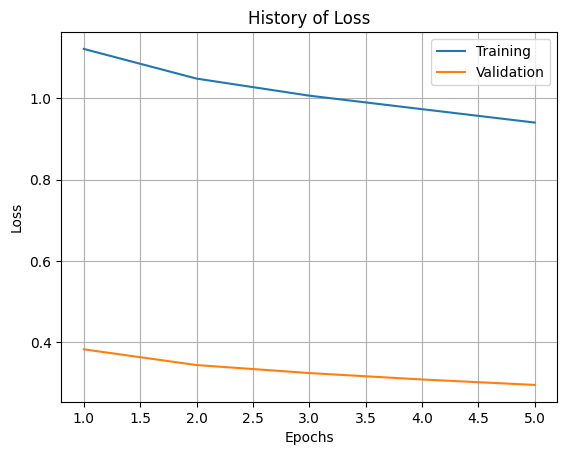

In [ ]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(range(1, EPOCHS + 1), train_loss, label='training loss')
ax1.plot(range(1, EPOCHS + 1), val_loss, label='validation loss')
ax1.set_title('History of Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['Training', 'Validation'])
ax1.grid()
plt.show()

In [ ]:
# saving the models
encoder.save('global_encoder')
decoder.save('global_decoder')

In [ ]:
# evaluation method
def evaluate(sentence):
  attention_plot = np.zeros((german_max_length, english_max_length))
  sentence = preprocess_sentence(sentence)
  inputs = [english_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=english_max_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  lstm_layer = tf.keras.layers.LSTM(units)
  initial_state = [tf.zeros((1, units)), tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, initial_state)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([german_tokenizer.word_index['<start>']], 0)

  for t in range(german_max_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += german_tokenizer.index_word[predicted_id] + ' '

    if german_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
      
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  return result

In [ ]:
sentence = '<start> you have requested a debate on this subject in the course of the next few days during this partsession <end>'
translate(sentence)

'die menschen in der ukraine und die ukraine im vergangenen jahr in der vergangenen jahr in der hauptstadt im jahr <end> '

# **d) Local Attention Model**

In [ ]:
class LocalAttention(Layer):
  def __init__(self, units, window_size):
    super(LocalAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)
    self.window_size = window_size

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query[0], 1)
    score = self.V(tanh(self.W1(query_with_time_axis) + self.W2(values)))
    start_index = tf.maximum(0, len(query) - self.window_size // 2)
    end_index = start_index + self.window_size

    attention_weights = softmax(score[:, start_index:end_index], axis=-1)
    context_vector = attention_weights * values[:, start_index:end_index, :]
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class LocalDecoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_size, window_size):
    super(LocalDecoder, self).__init__()
    self.batch_sz = batch_size
    self.dec_units = dec_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(self.dec_units,
                   return_sequences=True,
                   return_state=True,
                   recurrent_initializer='glorot_uniform')
    self.fc = Dense(vocab_size)
    self.attention = LocalAttention(self.dec_units, window_size)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state_h, state_c = self.lstm(x, initial_state=hidden)
    state = [state_h, state_c]
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

In [ ]:
local_encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
local_sample_hidden = local_encoder.initialize_hidden_state()
local_sample_output, local_sample_hidden = local_encoder(example_input_batch, local_sample_hidden)

print('Encoder Output Shape: (batch_size, sequence_length, units)', local_sample_output.shape)
print('Encoder Hidden State Shape: (batch_size, units)', local_sample_hidden[0].shape)

Encoder Output Shape: (batch_size, sequence_length, units) (32, 161, 512)
Encoder Hidden State Shape: (batch_size, units) (32, 512)


In [ ]:
local_attention_layer = LocalAttention(10, 50)
local_attention_result, local_attention_weights = local_attention_layer(local_sample_hidden, local_sample_output)

print("Attention Result Shape: (batch_size, units)", local_attention_result.shape)
print("Attention Weights Shape: (batch_size, sequence_length, 1)", local_attention_weights.shape)

Attention Result Shape: (batch_size, units) (32, 512)
Attention Weights Shape: (batch_size, sequence_length, 1) (32, 50, 1)


In [ ]:
local_decoder = LocalDecoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 50)
local_sample_decoder_output, local_sample_decoder_state, _ = local_decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      local_sample_hidden, local_sample_output)

print('Decoder Output Shape: (batch_size, vocab_size)', local_sample_decoder_output.shape, local_sample_decoder_state[0].shape)

Decoder Output Shape: (batch_size, vocab_size) (32, 26333) (32, 512)


In [ ]:
@tf.function
def local_train_step(inp, targ, enc_hidden, loss):
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = local_encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = local_decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = local_encoder.trainable_variables + local_decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [ ]:
EPOCHS = 5

train_loss = []
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = local_encoder.initialize_hidden_state()
  total_train_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    train_batch_loss = local_train_step(inp, targ, enc_hidden, 0)
    total_train_loss += train_batch_loss
  
  temp = "{:.4f}".format(total_train_loss/steps_per_epoch)
  train_loss.append(float(temp))

  print(f'Epoch: {epoch+1}, Training Loss: {total_train_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 Epoch {time.time()-start:.2f}s\n')

Epoch: 1, Training Loss: 1.1424
Time taken for 1 Epoch 266.99s

Epoch: 2, Training Loss: 1.0512
Time taken for 1 Epoch 134.01s

Epoch: 3, Training Loss: 0.9957
Time taken for 1 Epoch 134.02s

Epoch: 4, Training Loss: 0.9566
Time taken for 1 Epoch 134.00s

Epoch: 5, Training Loss: 0.9204
Time taken for 1 Epoch 134.33s



In [ ]:
@tf.function
def local_validation_step(inp, targ, enc_hidden, loss):
    enc_output, enc_hidden = local_encoder(inp, enc_hidden, training=False)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
        predictions, dec_hidden, _ = local_decoder(dec_input, dec_hidden, enc_output, training=False)
        loss += loss_function(targ[:, t], predictions)
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    return batch_loss

In [ ]:
# validation loop
EPOCHS = 5

val_loss = []
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = local_encoder.initialize_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(val_dataset.take(steps_per_epoch)):
    batch_loss = local_validation_step(inp, targ, enc_hidden, 0)
    total_loss += batch_loss
  
  temp = "{:.4f}".format(total_loss/steps_per_epoch)
  val_loss.append(float(temp))
  print(f'Epoch: {epoch+1}, Validation Loss: {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 Epoch {time.time()-start:.2f}s\n')

Epoch: 1, Validation Loss: 0.4369
Time taken for 1 Epoch 93.86s

Epoch: 2, Validation Loss: 0.4372
Time taken for 1 Epoch 21.77s

Epoch: 3, Validation Loss: 0.4381
Time taken for 1 Epoch 22.01s

Epoch: 4, Validation Loss: 0.4365
Time taken for 1 Epoch 21.89s

Epoch: 5, Validation Loss: 0.4362
Time taken for 1 Epoch 21.70s



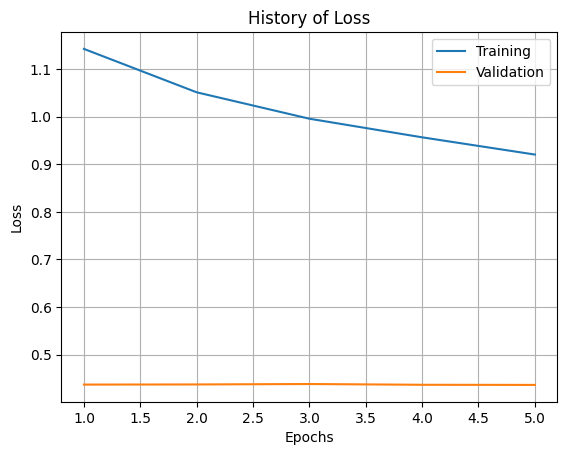

In [ ]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(range(1, EPOCHS + 1), train_loss, label='training loss')
ax1.plot(range(1, EPOCHS + 1), val_loss, label='validation loss')
ax1.set_title('History of Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['Training', 'Validation'])
ax1.grid()
plt.show()

In [ ]:
# evaluation method
def evaluate_local(sentence):
  attention_plot = np.zeros((german_max_length, english_max_length))
  sentence = preprocess_sentence(sentence)
  inputs = [english_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=english_max_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  lstm_layer = tf.keras.layers.LSTM(units)
  initial_state = [tf.zeros((1, units)), tf.zeros((1, units))]
  enc_out, enc_hidden = local_encoder(inputs, initial_state)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([german_tokenizer.word_index['<start>']], 0)

  for t in range(german_max_length):
    predictions, dec_hidden, attention_weights = local_decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = pad_sequences([attention_weights], padding='post', maxlen=161)
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += german_tokenizer.index_word[predicted_id] + ' '

    if german_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
      
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
sentence = '<start> you have requested a debate on this subject in the course of the next few days during this partsession <end>'
result, _, _ = evaluate_local(sentence)
result

'herr präsident ich möchte die kommission der kommission in der bericht in der bericht in der bericht <end> '

# **BLEU Score Calculation**

In [ ]:
import nltk

def calculate_bleu_score(actual, predicted):
    bleu_1_score = 0
    for i in range(len(actual)):
        ref = actual[i].split()
        cand = predicted[i].split()

        bleu_1 = nltk.translate.bleu_score.sentence_bleu([ref], cand, weights=(1, 0, 0, 0))
        bleu_1_score += bleu_1

    avg_bleu1 = bleu_1_score / len(actual)

    bleu_2_score = 0
    for i in range(len(actual)):
        ref = actual[i].split()
        cand = predicted[i].split()
        bleu_2 = nltk.translate.bleu_score.sentence_bleu([ref], cand, weights=(0.5, 0.5, 0, 0))
        bleu_2_score += bleu_2

    avg_bleu2 = bleu_2_score / len(actual)
    return avg_bleu1, avg_bleu2

In [ ]:
def make_predictions(test_sentences):
  predictions = []

  for i in range(len(test_sentences)):
    sentence = test_sentences[i].replace('  ', ' ')
    try:
      german_sent = '<start> ' + translate(sentence)
      predictions.append(german_sent)
    except:
      print(sentence)
      break

  return predictions

In [ ]:
def make_local_predictions(test_sentences):
  predictions = []

  for i in range(len(test_sentences)):
    sentence = test_sentences[i].replace('  ', ' ')
    try:
      result, _, _ = evaluate_local(sentence)
      german_sent = '<start> ' + result
      predictions.append(german_sent)
    except:
      print(sentence)
      break

  return predictions

### **for Vanilla LSTM Mechanism**

In [ ]:
blue1_list = []
bleu2_list = []

for actual_sent, predicted_sent in zip(actual_words, predicted_words):
  bleu_1, bleu_2 = calculate_bleu_score(actual_sent, predicted_sent)
  blue1_list.append(bleu_1)
  bleu2_list.append(bleu_2)

In [ ]:
print(f"BLEU-1 Score: {sum(blue1_list)/len(blue1_list)}")
print(f"BLEU-2 Score: {sum(bleu2_list)/len(bleu2_list)}")

BLEU-1 Score: 0.12888133340157987
BLEU-2 Score: 0.009027391633145242


### **for Global Attention Mechanism**

In [ ]:
predictions = make_predictions(test_english)
predictions

In [ ]:
bleu_1, bleu_2 = calculate_bleu_score(test_german, predictions)

In [ ]:
print(f"BLEU-1 Score: {bleu_1}")
print(f"BLEU-2 Score: {bleu_2}")

BLEU-1 Score: 0.1893107483811143
BLEU-2 Score: 0.02167383286284155


### **for Local LSTM Mechanism**

In [ ]:
local_predictions = make_local_predictions(test_english)
local_predictions

In [ ]:
bleu_1, bleu_2 = calculate_bleu_score(test_german, local_predictions)

In [ ]:
print(f"BLEU-1 Score: {bleu_1}")
print(f"BLEU-2 Score: {bleu_2}")

BLEU-1 Score: 0.18510687962962044
BLEU-2 Score: 0.020196165307957478


# **Rough-L Score Calculation**

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge
rouge = Rouge()

### **For Vanilla LSTM Mechanism**

In [ ]:
rouge_scores = []
for actual_sent, predicted_sent in zip(actual_words, predicted_words):
  ans = rouge.get_scores(predicted_sent, actual_sent, avg=True)
  rouge_scores.append(ans['rouge-l']['f'])

In [ ]:
print(f"Rouge-L on the Test Set: {sum(rouge_scores)/len(rouge_scores)}")

Rouge-L on the Test Set: 0.20387218348157077


### **For Global Attention Mechanism**

In [ ]:
result = rouge.get_scores(predictions, test_german, avg=True)
print(f"Rouge-L Score on the Test Set: {result['rouge-l']['f']}")

Rouge-L Score on the Test Set: 0.2379550835847547


### **For Local LSTM Mechanism**

In [ ]:
result = rouge.get_scores(local_predictions, test_german, avg=True)
print(f"Rouge-L Score on the Test Set: {result['rouge-l']['f']}")

Rouge-L Score on the Test Set: 0.25796982971926946
